# 12 Clipping

In this lesson we will learn how to to clip different geometries.

## About the data

We will use three datasets in this lesson. 

The first dataset is a [TIGER shapefile of the US states from the United States Census Bureau](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2022.html#list-tab-790442341). Follow these steps to download shapefile with the United States' states:

You can check the [metadata for all the TIGER shapefiles here](https://www.census.gov/programs-surveys/geography/technical-documentation/complete-technical-documentation/tiger-geo-line.html). 

The second dataset we'll use is [Natural Earth's simple medium scale populated places dataset](https://www.naturalearthdata.com/downloads/50m-cultural-vectors/). We can obtain this dataset by downloading the shapefile (choose the one that says "simple (less columns)").

The third dataset we'll use is [Natural Earth's road dataset](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/roads/). 
We can obtain this dataset by downloading the shapefile 

We will combine these datasets to create the following map of infrastructure in Alaska:

## Import data

Let's start by loading our libraries and then importing the datasets we will use.


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

from shapely.geometry import box  # To create polygon bounding box

"""
Set environment variable 'PROJ_LIB' to specify the path for the PROJ library
Resolves ERROR 1: PROJ: proj_create_from_database
"""""
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

pd.set_option("display.max.columns", None)

# -------------------------------------------------------
# Import data

# Path to course data folder
data_folder_fp = os.path.join('/',
                              'courses',
                              'EDS220', 
                              'data')

# Import and simplify states polygons
states = gpd.read_file(os.path.join(data_folder_fp, 
                                    'tl_2022_us_state', 
                                    'tl_2022_us_state.shp'))

# Import Natural Earth populated places points
places = gpd.read_file(os.path.join(data_folder_fp,
                                    'ne_50m_populated_places',
                                    'ne_50m_populated_places.shp')
                                    )

# Import ferry routes lines
roads = gpd.read_file(os.path.join(data_folder_fp,
                                   'ne_10m_roads',
                                   'ne_10m_roads.shp')
                                   )

## Check-in
Use a for loop to iterate over the three geo-dataframes we imported and change their column names to lower caps.

In [9]:
for df in [states, places, roads]:
    df.columns = df.columns.str.lower()

## Prepare Alaska multipolygon

This is a geospatial dataset, exploration should include at *least* check:

CRS, plotting the data, and head of the dataset

In [10]:
print(f"CRS: {states.crs}")

states.head(3)

CRS: GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]


,region,division,statefp,statens,geoid,stusps,name,lsad,mtfcc,funcstat,aland,awater,intptlat,intptlon,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266456923,489045863,+38.6472854,-080.6183274,"POLYGON ((-77.75438 39.33346, -77.75422 39.333..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138962819934,45971472526,+28.3989775,-082.5143005,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143778515726,6216539665,+40.1028754,-089.1526108,"POLYGON ((-87.89243 38.28285, -87.89334 38.282..."


<Axes: >

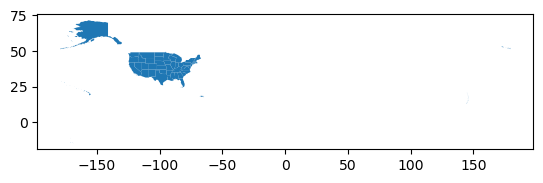

In [11]:
states.plot()

For this lesson, we are interested in plotting data in Alaska only.

<Axes: >

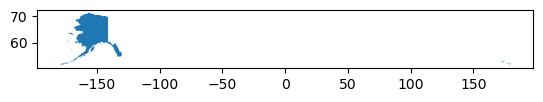

In [12]:
alaska = states[states.name == 'Alaska']
alaska.plot()

Notice the multipolygon is plotted under the NAD83/EPSG:4269 CRS (common for US agencies data) and this unnaturally elongates the map. 

Let's reproject to EPSG:3338, this is a *projected* CRS. 

Site for info about CRSs: https://spatialreference.org/ref/epsg/3338/

In [14]:
# Reproject to CRS optimized for Alaska
alaska = alaska.to_crs('epsg:3338')

# Inspect new CRS
print('Is this CRS projected? ', alaska.crs.is_projected)
alaska.crs

Is this CRS projected?  True


<Projected CRS: EPSG:3338>
Name: NAD83 / Alaska Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Alaska.
- bounds: (172.42, 51.3, -129.99, 71.4)
Coordinate Operation:
- name: Alaska Albers (meter)
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Prepare populated places points

Let's explore the data: 

In [15]:
places.crs

<Geographic 2D CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
places.head(3)

,scalerank,natscale,labelrank,featurecla,name,namepar,namealt,nameascii,adm0cap,capin,worldcity,megacity,sov0name,sov_a3,adm0name,adm0_a3,adm1name,iso_a2,note,latitude,longitude,pop_max,pop_min,pop_other,rank_max,rank_min,meganame,ls_name,max_pop10,max_pop20,max_pop50,max_pop300,max_pop310,max_natsca,min_areakm,max_areakm,min_areami,max_areami,min_perkm,max_perkm,min_permi,max_permi,min_bbxmin,max_bbxmin,min_bbxmax,max_bbxmax,min_bbymin,max_bbymin,min_bbymax,max_bbymax,mean_bbxc,mean_bbyc,timezone,un_fid,pop1950,pop1955,pop1960,pop1965,pop1970,pop1975,pop1980,pop1985,pop1990,pop1995,pop2000,pop2005,pop2010,pop2015,pop2020,pop2025,pop2050,min_zoom,wikidataid,wof_id,capalt,name_en,name_de,name_es,name_fr,name_pt,name_ru,name_zh,label,name_ar,name_bn,name_el,name_hi,name_hu,name_id,name_it,name_ja,name_ko,name_nl,name_pl,name_sv,name_tr,name_vi,ne_id,name_fa,name_he,name_uk,name_ur,name_zht,geonamesid,fclass_iso,fclass_us,fclass_fr,fclass_ru,fclass_es,fclass_cn,fclass_tw,fclass_in,fclass_np,fclass_pk,fclass_de,fclass_gb,fclass_br,fclass_il,fclass_ps,fclass_sa,fclass_eg,fclass_ma,fclass_pt,fclass_ar,fclass_jp,fclass_ko,fclass_vn,fclass_tr,fclass_id,fclass_pl,fclass_gr,fclass_it,fclass_nl,fclass_se,fclass_bd,fclass_ua,fclass_tlc,geometry
0,10,1,5,Admin-1 region capital,Bombo,None,None,Bombo,0,None,0,0,Uganda,UGA,Uganda,UGA,Bamunanika,UG,None,0.583299,32.533300,75000,21000,0.0,8,7,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,Q4940747,1141906025,0,Bombo,Bombo,Bombo,Bombo,Bombo,Бомбо,邦博,None,بومبو,বোম্বো,Μπόμπο,बॉम्बो,Bombo,Bombo,Bombo,ボンボ,봄보,Bombo,Bombo,Bombo,Bombo,Bombo,1159113923,بمبو,בומבו,Бомбо,بومبو,邦博,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (32.53330 0.58330)
1,10,1,5,Admin-1 region capital,Fort Portal,None,None,Fort Portal,0,None,0,0,Uganda,UGA,Uganda,UGA,Kabarole,UG,None,0.671004,30.275002,42670,42670,0.0,7,7,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Africa/Kampala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,Q500107,421174009,0,Fort Portal,Fort Portal,Fort Portal,Fort Portal,Fort Portal,Форт-Портал,波特爾堡,None,فورت بورتال,ফোর্ট পোর্টাল,Φορτ Πορτάλ,फोर्ट पोर्टल,Fort Portal,Fort Portal,Fort Portal,フォート・ポータル,포트포털,Fort Portal,Fort Portal,Fort Portal,Fort Portal,Fort Portal,1159113959,فورت پورتال,פורט פורטל,Форт-Портал,فورٹ پورٹل,波特爾堡,233476.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (30.27500 0.67100)
2,10,1,3,Admin-1 region capital,Potenza,None,None,Potenza,0,None,0,0,Italy,ITA,Italy,ITA,Basilicata,IT,None,40.642002,15.798997,69060,69060,0.0,8,8,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Europe/Rome,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,Q3543,101752567,0,Potenza,Potenza,Potenza,Potenza,Potenza,Потенца,波坦察,None,بوتنسا,পোটেঞ্জা,Ποτέντσα,पोटेंजा,Potenza,Potenza,Potenza,ポテンツァ,포텐차,Potenza,Potenza,Potenza,Potenza,Potenza,1159117259,پوتنزا,פוטנצה,Потенца,پوتینتسا,波坦察,3170027.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (15.79900 40.64200)


<Axes: >

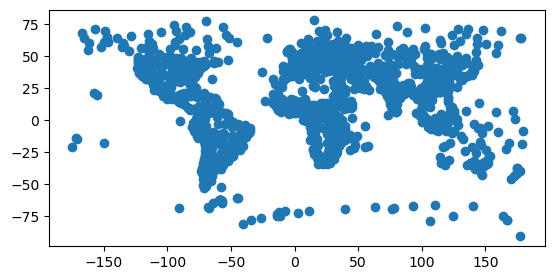

In [17]:
places.plot()

This dataset is in WGS84/EPSG:4326 CRS.

This is the most widely used CRS for global data

Let's try to plot it on top of Alaska

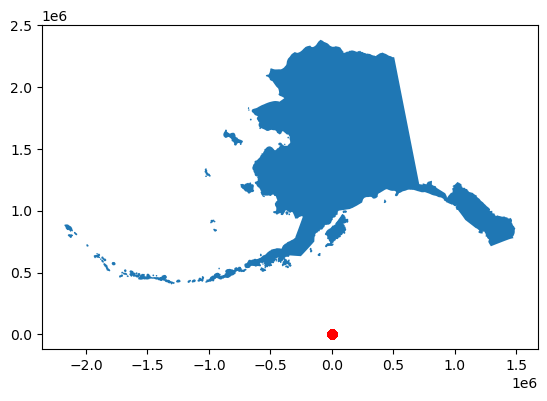

In [18]:
fig, ax = plt.subplots()

alaska.plot(ax=ax)
places.plot(ax=ax, color = 'red')

plt.show()

**IF your data is in weird places, check that the CRSs match**

Let's update the CRSs use an `if-else` statement:

In [19]:
if alaska.crs == places.crs:
    print('CRSs match')
else:
    places = places.to_crs(alaska.crs)
    assert places.crs == alaska.crs
    print('We matched the CRSs')

We matched the CRSs


Remember that an `if-else` statement is a control structure that allows code to make decisions:

- it checks a condidtion,
- if that condition is true, it executes one block of the code (if `if` block)
- if the condition is flase, it executes a difference bloc (the `else` block)

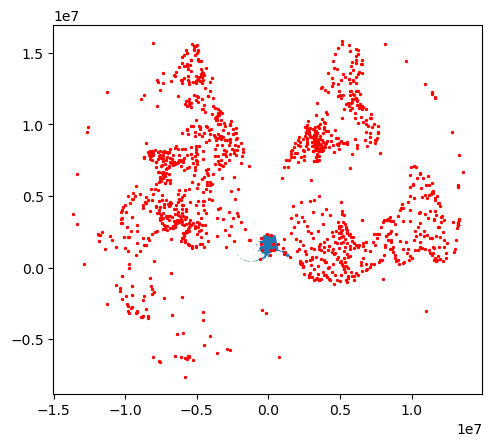

In [20]:
# Let's try the plot again

fig, ax = plt.subplots()

alaska.plot(ax=ax)
places.plot(ax=ax, color='red', markersize=2)

plt.show()

## Clipping

**Clipping** means using a polygon (or polygons) to only select geospatial data within them.

Clipping a `geopandas.GeoDataFrame` is simple using the geopandas `clip()` function. 

The general syntax is:

```python
updated_geodf = geopandas.clip(geodf, mask)
```

where

- `updated_geodf` is the output of the method: the **intersection** of the geometries in `geodf` with `mask`
- `geodf` is the `geopandas.GeoDataFrame` we want to clip
- `mask`is a `geopandas.GeoDataFrame` with the polygon(s) we want to use for clipping. This `mask` must be in the same CRS as `geodf`!

In our case:

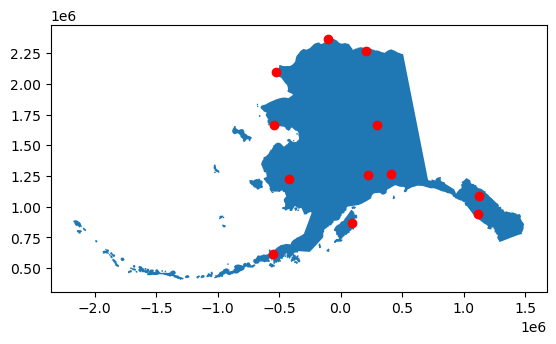

In [21]:
# Clip populated places to the alaska multipolygon
ak_places = gpd.clip(places, alaska)

# Plot it
fig, ax = plt.subplots()

alaska.plot(ax=ax)
ak_places.plot(ax=ax, color='red')

plt.show()

## Prepare roads data

In [22]:
roads.crs

<Geographic 2D CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [23]:
roads.head(3)

,scalerank,featurecla,type,sov_a3,note,edited,name,namealt,namealtt,routeraw,question,length_km,toll,ne_part,label,label2,local,localtype,localalt,labelrank,ignore,add,rwdb_rd_id,orig_fid,prefix,uident,continent,expressway,level,min_zoom,min_label,geometry
0,8,Road,Secondary Highway,CAN,None,"Version 1.5: Changed alignment, a few adds in ...",None,None,None,None,0,3,0,ne_1d4_original,None,None,None,None,None,0,0,0,0,0,None,314705,North America,0,None,7.1,9.6,"LINESTRING (-133.32533 62.21571, -133.31664 62..."
1,7,Road,Secondary Highway,USA,None,"Version 1.5: Changed alignment, a few adds in ...",83,None,None,None,0,164,0,ne_1d4_original,None,None,None,None,None,0,0,0,0,0,None,108105,North America,0,Federal,7.0,8.6,"LINESTRING (-100.50543 42.80753, -100.53495 42..."
2,7,Road,Secondary Highway,USA,None,"Version 1.5: Changed alignment, a few adds in ...",840,None,None,None,0,98,0,ne_1d4_original,None,None,None,None,None,0,0,0,0,0,None,0,North America,0,U/C,7.0,9.5,"LINESTRING (-87.27432 36.02439, -87.22916 35.9..."


<Axes: >

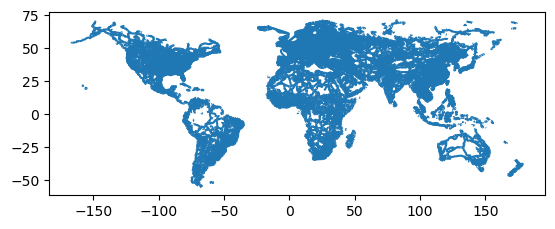

In [24]:
roads.plot()

You may have already noticed that the `roads` data is not in the same CRS as the `alaska` polygons, so these geo-datasets shound’t interact until they’re in the same CRS. Before jumping right into reprojecting and clipping, we will subset the data to select only US roads:

**BEST PRACTICE**

Reduce your tabular data before reducing via geometries.

Geospatial operations are usually costly in terms of computing power. The more detailed our geometries are, the longer in takes to do geospatial computations. It’s a good practice to reduce your data as much as possible before applying any geospatial transformation.

<Axes: >

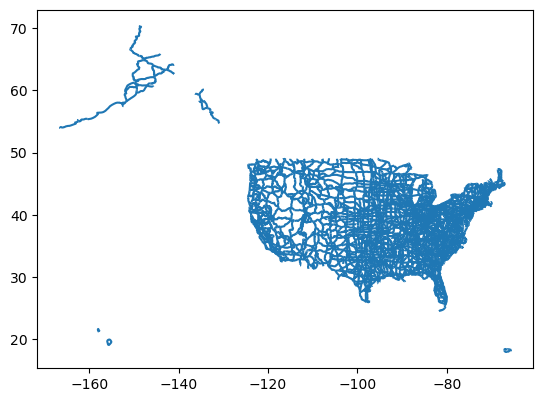

In [25]:
usa_roads = roads[roads.sov_a3 == 'USA']
usa_roads.plot()

We will now compose functions to clip `usa_roads` and `alaska` multipolygon.

In [28]:
# Clip usa_roads to alaska geometry
ak_roads = gpd.clip(usa_roads.to_crs(alaska.crs), alaska)

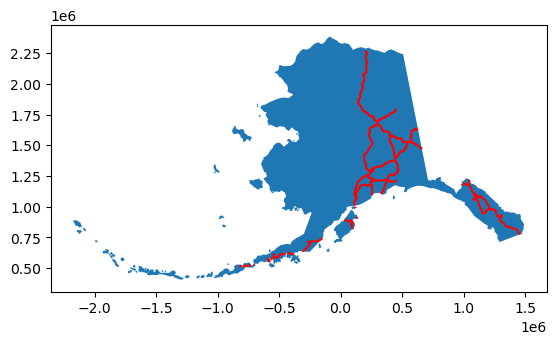

In [29]:
fig, ax = plt.subplots()
alaska.plot(ax=ax)
ak_roads.plot(ax=ax, color='red')
fig.show()

Notice how the lines break on the small islands? However, in the usa_roads there are no broken lines. This should make us suspect we are leaving data out and clipping exactly to the polygons in alaska is not quite what we want.

## Clipping with a bounding box

We will clip the `usa_roads` geo-dataframe with the **bounding box** of `alaska` instead of its polygons. 

To create a bounding box, we first use the `box()` function we imported from `shapely.geometry`. 

The syntax for `box()` is:

```python
box(minx, miny, maxx, maxy)
```

the output is a polygon representing a box constructed like this:

(See diagram in class notes)

If we want to create a `shapely` polygon from the bounds of a geo-dataframe `gdf`, a more straightforward syntax is:

```python
box(*gdf.total_bounds)
```

In [30]:
alaska.total_bounds

array([-2175729.73162241,   404545.10791528,  1493082.30904445,
        2383808.43520816])

<class 'shapely.geometry.polygon.Polygon'>


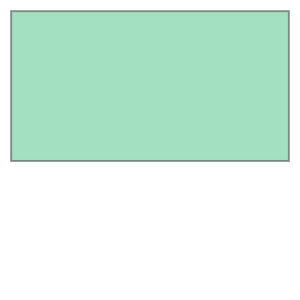

In [31]:
bbox = box(*alaska.total_bounds)
print(type(bbox))
bbox

### * = unpacking operator

In the last syntax we used the **asterisk `*` as an unpacking operator** on the array `alaska.total_bounds`. Think about it as unpacking the elements of `alaska.total_bounds` and assigning them one-by-one to the paremeters `minx, miny, maxx, maxy` of the `box()` function.

This is a good article explaining more about unpacking with `*` in Python: https://geekflare.com/python-unpacking-operators/

Notice that the bounding box is not a geodataframe, it is a stand alone, abstract polygon without any geospatial information. To interpret this polygon as something on the Earth’s surface we need to wrap it into a geo-datfrane abd assign it a CRS:

In [32]:
# Create a geodataframe from the bounding box
ak_bbox = gpd.GeoDataFrame(geometry = [bbox],  # Assign geometry column
                          crs = alaska.crs)    # Assign a CRS
print(type(ak_bbox))
ak_bbox

<class 'geopandas.geodataframe.GeoDataFrame'>


,geometry
0,"POLYGON ((1493082.309 404545.108, 1493082.309 ..."


In [33]:
# Clip roads using Alaska bounding box
ak_complete_roads = gpd.clip(usa_roads.to_crs(ak_bbox.crs), ak_bbox)

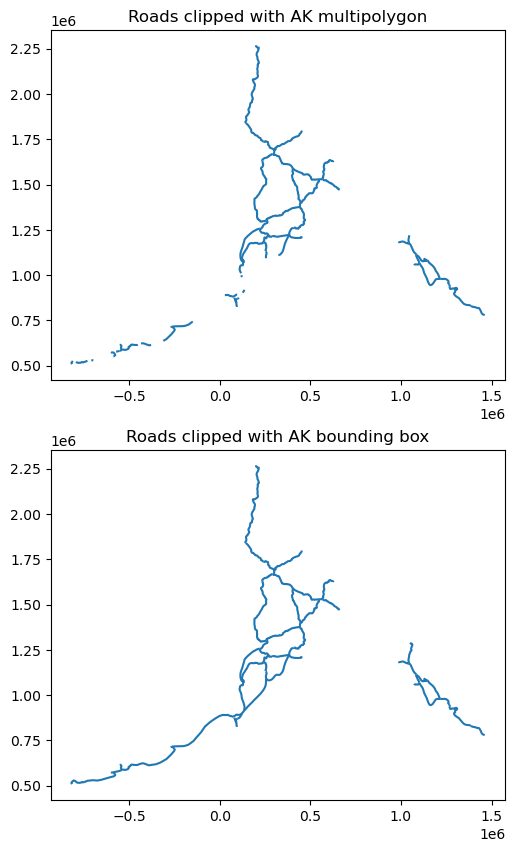

In [34]:
# See the difference between the two clipping methods
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

ak_roads.plot(ax=ax1)
ax1.set_title('Roads clipped with AK multipolygon')

ak_complete_roads.plot(ax=ax2)
ax2.set_title('Roads clipped with AK bounding box')

plt.show()

Let's plot all the layers together

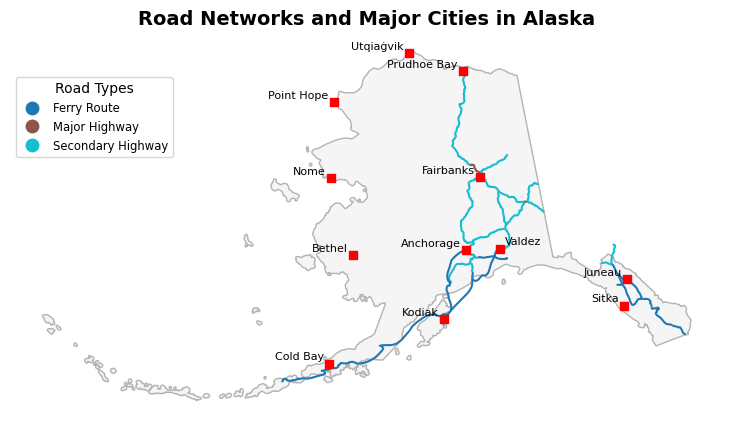

In [64]:
fig, ax = plt.subplots(figsize = (11,5))
ax.axis('off')

alaska.plot(ax=ax, color='whitesmoke', edgecolor='0.7')

ak_complete_roads.plot(ax=ax,
                       zorder=1,  # specify the layer plotting order
                      column='type',
                      legend=True,
                        legend_kwds={'title': "Road Types", 
                                    'loc': 'upper left',
                                    'bbox_to_anchor':(0,0.9),
                                    'fontsize':'small'})
ak_places.plot(ax=ax,
               zorder=2,
         color='red',
         marker='s',  # square marker
         )

# Add city names as text annotations
for x, y, name in zip(ak_places.geometry.x, ak_places.geometry.y, ak_places['name']):
    if name == 'Valdez':
        ax.text(x+30000, y+20000, name, fontsize=8, ha='left')
    else:
        ax.text(x-30000, y+20000, name, fontsize=8, ha='right')
   
        

ax.set_title("Road Networks and Major Cities in Alaska", fontsize=14, fontweight='bold')

plt.show()